# Multiclass image segmentation for different loss functions(Dice loss, Focal loss, Total loss = (Summation of Dice and focal loss) ) 

**The main purpose of this notebook is to show the pipeline for using the above loss functions in Multiclass semantic image segmentation**

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

import tensorflow.python.keras as keras

import matplotlib as mpl
from matplotlib import patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import pandas as pd 
import os
from matplotlib.pyplot import imread
#ggplot
plt.style.use('classic')
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical   
import cv2
import gc
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from scipy import io, misc
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# from keras.utils import np_utils
import segmentation_models as sm
from segmentation_models import get_preprocessing, Unet
from segmentation_models.utils import set_trainable
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, dice_loss, jaccard_loss
from segmentation_models.metrics import iou_score, f1_score
from tensorflow import keras



from keras.metrics import MeanIoU
from keras import backend as K
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle

from tensorflow import keras
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler, LambdaCallback
from keras.optimizers import Adam

from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import PIL
import skimage
import torchvision.transforms as T
from PIL import Image

Segmentation Models: using `keras` framework.


In [30]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1.0)
tf.compat.v1.GPUOptions(allow_growth=True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# !git clone https://github.com/bearpaw/clothing-co-parsing.git
# !echo pwd
# %env SM_FRAMEWORK=tf.keras
# !pip3 install segmentation_models

# Image processing and agumentation for segmentation

In [13]:
IMAGE_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/Face_Segments/img'
MASK_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/mask_mat'
#sort the images and masks
image_dir = sorted(os.listdir(IMAGE_PATH))
mask_dir = sorted(os.listdir(MASK_PATH))


In [57]:
factor = 0.1
def process_x(files,dsize = (256,256)):
  x = []
  for img in files:
      
      img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
      x.append(img)
    
  return np.array(x).astype("float32")     

def process_y(files,dsize = (256,256),cat = False , n_classes = 5 ):
    
    masks = []
    for img in files:
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(res)
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
    if(cat):
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        return y_train_cat
    else:
        return train_masks_input


def process_x1(files,dsize = (256,256) ):

  # files = [i for i in files] 
  
  x = []
  X = []
  for img in files:
    img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
    x.append(img)
  for i in x :
      image = tf.cast(tf.convert_to_tensor(i), tf.float32)
      X.append(image)
  return X 

def process_y1(files,dsize = (256,256) , cat = False , n_classes = 5 ):
    
    masks = []
    Y = []
    for img in files:
        
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(tf.convert_to_tensor(res))
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    if(cat == False):

        # train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        for mask in  train_masks_encoded_original_shape:
            m = tf.expand_dims(tf.convert_to_tensor(mask), axis=-1)
            m = tf.cast(m, tf.float32)
            Y.append(m)
        return Y
    else:
        train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        for mask in y_train_cat:
             m = tf.cast(tf.convert_to_tensor(mask), tf.float32)
             Y.append(m)
        return Y 
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

#+0.1
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, factor)
    return img, mask
#+0.1
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, factor)
    return img, mask
#-0.1
def hue(img, mask):
    img = tf.image.adjust_hue(img, -factor)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def rotate_n_deg(img, mask):
    img = tf.image.rot90(img, k=factor)
    mask = tf.image.rot90(mask, k=factor)
    return img, mask




def further_process(X_train,y_train,X_val,y_val,BATCH = 4, augmentations = 4 ):
    
    train_X = tf.data.Dataset.from_tensor_slices(X_train)
    val_X = tf.data.Dataset.from_tensor_slices(X_val)

    train_y = tf.data.Dataset.from_tensor_slices(y_train)
    val_y = tf.data.Dataset.from_tensor_slices(y_val)

    # print(train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec)

    train = tf.data.Dataset.zip((train_X, train_y))
    traina = train
    trainb = traina
    trainc = traina
    val = tf.data.Dataset.zip((val_X, val_y))
    print("train length before augmentation", len(list(train.as_numpy_iterator())))
    print("val length before augmentation", len(list(val.as_numpy_iterator())))

    # perform augmentation on train data only
    for i in range(0,2):
        factor = 0.1*i

        if i == 0:
            factor = 0.1
            print(f"factor is {factor}")
        if i == 1:
            factor = -0.1
            print(f"factor is {factor}")
        if i == 2:
            break
        a = train.map(brightness)
        b = train.map(gamma)
        c = train.map(hue)
        # d = train.map(crop)
        if i == 0:
            # e = train.map(flip_hori)
            f = train.map(flip_vert)
        g = trainb.map(rotate)

        train = train.concatenate(a)
        train = train.concatenate(b)
        train = train.concatenate(c)
        # train = train.concatenate(d)
        # train = train.concatenate(e)
        if i == 0:
            train = train.concatenate(f)
        train = train.concatenate(g)

        
    for i in range(0,2):
        factor = 0.1*i

        if i == 0:
            factor = 0.1
            print(f"factor is {factor}")
        if i == 1:
            factor = -0.1
            print(f"factor is {factor}")
        if i == 2:
            break
        a = val.map(brightness)
        b = val.map(gamma)
        c = val.map(hue)
        # d = train.map(crop)
        if i == 0:
            # e = train.map(flip_hori)
            f = val.map(flip_vert)
        g = val.map(rotate)

        val = val.concatenate(a)
        val = val.concatenate(b)
        val = val.concatenate(c)
        # train = train.concatenate(d)
        # train = train.concatenate(e)
        if i == 0:
            val = val.concatenate(f)
        val = val.concatenate(g)
    print("train length after augmentation", len(list(train.as_numpy_iterator())))
    print("val length after augmentation", len(list(val.as_numpy_iterator())))
    STEPS_PER_EPOCH = len(list(train.as_numpy_iterator()))//BATCH
    VALIDATION_STEPS = len(list(val.as_numpy_iterator()))//BATCH
    AT = tf.data.AUTOTUNE
    BUFFER = len(X_train) + len(X_val)
    print("BUFFER " , BUFFER )

    # STEPS_PER_EPOCH = len(X_train)//BATCH
    # VALIDATION_STEPS = len(X_val)//BATCH

    # print("STEPS_PER_EPOCH " , STEPS_PER_EPOCH)
    # print("VALIDATION_STEPS " , VALIDATION_STEPS)



    train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
    train = train.prefetch(buffer_size=AT)
    val = val.batch(BATCH)
    print(f"steps per epoch {STEPS_PER_EPOCH}")
    print(f"validation steps {VALIDATION_STEPS}")

    return (train,val,STEPS_PER_EPOCH, VALIDATION_STEPS)

['.ipynb_checkpoints', '060002_4_028450_FEMALE_30.jpg', '060003_4_028451_MALE_65.jpg', '060004_4_028452_MALE_31.jpg', '060005_4_023834_FEMALE_33.jpg', '060006_4_015021_FEMALE_39.jpg', '060009_4_019350_FEMALE_21.jpg', '060012_4_020004_MALE_27.jpg', '060013_4_014380_MALE_34.jpg', '060014_4_016695_MALE_43.jpg', '060019_4_028457_MALE_33.jpg', '060020_3_024801_NONE_28.jpg', '060027_4_025986_FEMALE_36.jpg', '060028_4_022580_NONE_25.jpg', '060032_4_027166_MALE_28.jpg', '060033_4_028462_MALE_19.jpg', '060037_4_028465_FEMALE_23.jpg', '060038_4_028466_MALE_19.jpg', '060040_4_015000_FEMALE_39.jpg', '060043_4_028470_FEMALE_19.jpg', '060047_4_027403_MALE_25.jpg', 'flip.ipynb']
060002_4_028450_FEMALE_301673045657.mat
060003_4_028451_MALE_651673045658.mat
060004_4_028452_MALE_311673045647.mat
060005_4_023834_FEMALE_331673045643.mat
060006_4_015021_FEMALE_391673045638.mat
060009_4_019350_FEMALE_211673045667.mat
060012_4_020004_MALE_271673045666.mat
060013_4_014380_MALE_341673045655.mat
060014_4_016695

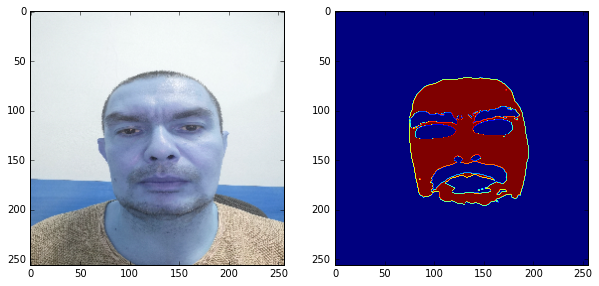

20
20


In [36]:
images =[]
test_images = []
#import sorting directories
import os
from os import listdir
from os.path import isfile, join
last = 0
curr = 0
#sort images
print(image_dir)
for img in image_dir:
    if img.__contains__(".ipynb_checkpoints") or img.__contains__("flip"):
        continue
    img = cv2.imread(os.path.join(IMAGE_PATH,img))
    # img = cv2.resize(img, (256,256))/255.0
    img = cv2.resize(img, (256,256))
    images.append(img)
    
masks = []
skin_color = (212,198,169)
for mask in mask_dir:
    print(mask)
    mask = os.path.join(MASK_PATH,mask)
    file = io.loadmat(mask)
    img = file['M'].astype(np.uint8)

    #create binary mask for skin
    img = np.where(img != skin_color , (0,0,0), img)
    img = np.where(img == skin_color , (255,255,255), img)  
    img = np.asarray(img).astype(np.uint8)
    img = cv2.resize(img, (256,256))
    #convert to binary mask
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.0
    masks.append(img)



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[1])
ax[1].imshow(masks[1])
plt.show()
print(len(images))
print(len(masks))

In [37]:
images[0].shape , masks[0].shape

((256, 256, 3), (256, 256))

In [ ]:
# Create a mapping between RGB labels and categorical labels

label_mapping = {
    (212,198,169): 'skin',
    (1,79,151): 'eye1',
    (0,0,0): 'eye2',
    (241,140,184): 'lips',
    (141,136,124): 'nostrils',
    (138,137,21): 'eyebrows',
    (105,67,116): 'hair',
    (255,81,46): 'clothes',
    (255,255,255): 'background'
}

binary_label_mapping = {
    (212,198,169): 1,
    (1,79,151): 0,
    (0,0,0): 0,
    (241,140,184): 0,
    (141,136,124): 0,
    (138,137,21): 0,
    (105,67,116): 0,
    (255,81,46): 0,
    (255,255,255): 0
}
    
print(label_mapping)
print(np.asarray(images).shape)
print(np.asarray(masks).shape)
# h, w = masks[0].shape
# n = len(masks)

{(212, 198, 169): 'skin', (1, 79, 151): 'eye1', (0, 0, 0): 'eye2', (241, 140, 184): 'lips', (141, 136, 124): 'nostrils', (138, 137, 21): 'eyebrows', (105, 67, 116): 'hair', (255, 81, 46): 'clothes', (255, 255, 255): 'background'}
(20, 256, 256, 3)
(20, 256, 256)


[0.         0.01568627 0.02745098 0.06666667 0.07843137 0.08627451
 0.11764706 0.1254902  0.14117647 0.20392157 0.23529412 0.29411765
 0.29803922 0.36078431 0.37647059 0.38431373 0.38823529 0.41960784
 0.42352941 0.45098039 0.46666667 0.47843137 0.48235294 0.49803922
 0.51372549 0.56078431 0.59607843 0.60784314 0.62352941 0.63137255
 0.63921569 0.64313725 0.67843137 0.70196078 0.73333333 0.76470588
 0.77254902 0.79607843 0.85490196 0.8745098  0.88235294 0.92156863
 0.9254902  0.92941176 0.9372549  0.94901961 0.95294118 0.97647059
 0.98823529 0.99607843 1.        ]
(256, 256)
[0.         0.01568627 0.02745098 0.06666667 0.07843137 0.08627451
 0.11764706 0.1254902  0.14117647 0.20392157 0.23529412 0.29411765
 0.29803922 0.36078431 0.37647059 0.38431373 0.38823529 0.41960784
 0.42352941 0.45098039 0.46666667 0.47843137 0.48235294 0.49803922
 0.51372549 0.56078431 0.59607843 0.60784314 0.62352941 0.63137255
 0.63921569 0.64313725 0.67843137 0.70196078 0.73333333 0.76470588
 0.77254902 0.79

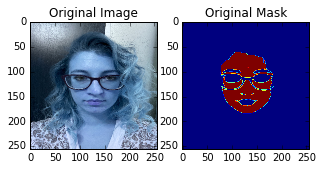

In [38]:

#classes = [ 0  5 19 39 41 42 45 47 55]
mask0 = masks[2]
# mask0_41 = np.where(mask0 != 41 , 0, mask0)

#make figure with mask0 mask0_41 and original image
fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(images[0])
ax[0].set_title("Original Image")
ax[1].imshow(masks[0])
ax[1].set_title("Original Mask")
#print number of classes in mask0
print(np.unique(mask0)) 
#convert all non skin classes to 0
#get class label for skin
skin_class = np.unique(mask0)
print(mask0.shape)
color = (212,198,169)

#print unique colors in mask0
print(np.unique(mask0))
#convert to binary mask for skin

#create binary mask for skin
# mask0_skin = np.where(mask0 != color , 0, mask0)
# mask0_skin = np.where(mask0_skin == color , (255,255,255), mask0_skin)
# plt.imshow(masks[0])
# plt.show()




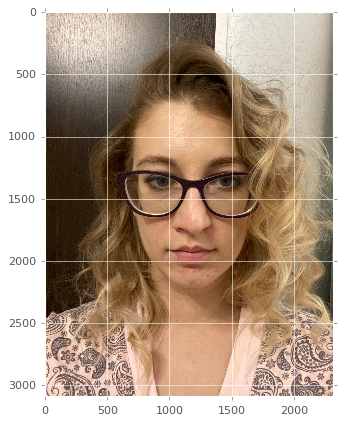

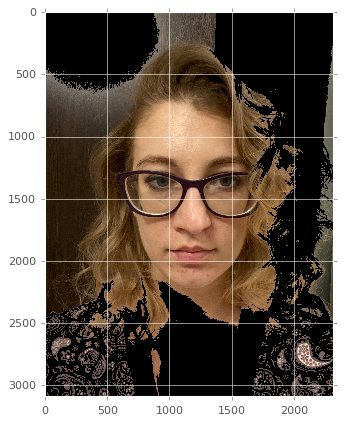

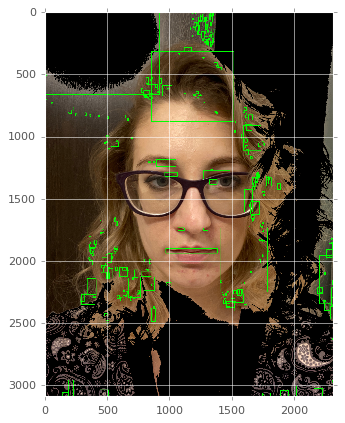

In [ ]:
from PIL import Image, ImageEnhance, ImageFilter
image = Image.open(r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/Face_Segments/img/060002_4_028450_FEMALE_30.jpg')
image = np.asarray(image)
gausian = cv2.GaussianBlur(image, (5, 5), 0)
plt.imshow(image)
plt.show()
# Convert the image to grayscale
gray = cv2.cvtColor(gausian, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
threshold, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# Find the contours of the foreground objects
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask with the same size as the input image
mask = np.zeros_like(image)

# Fill the contours with white on the mask
cv2.fillPoly(mask, contours, (255, 255, 255))

# Use the mask to remove the background from the image
masked_image = cv2.bitwise_and(image, mask)
plt.imshow(masked_image)
plt.show()

# Load the image
# image = cv2.imread(r'/Users/joeljohnson/Desktop/Joel/semantic segmentationRD_Mac/clothing-co-parsing/photos/0003.jpg')
image = cv2.GaussianBlur(masked_image, (5, 5), 0)
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
threshold, binary = cv2.threshold(gray, 0, 240, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# Find the contours of the foreground objects
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and draw a rectangle around the person
for contour in contours:
    if cv2.contourArea(contour) > 30:  # Only select contours with large enough areas
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Show the resulting image
plt.imshow(image)
plt.show()

Parameters for Unet

In [39]:
EPOCHS = 10
BATCH_SIZE = 8
TRAIN_SIZE  = 18
VAL_SIZE = 2
NUM_SAMPLES = 20
LEARING_RATE = 1e-4
MIN_LR = 1e-7
SMOOTH = 1e-12
RND_SEED = 7
KERNEL_INITIALIZER = "he_normal"
# KI_2 = "gaussian_normal"
DROPOUT = 0.1

PATIENCE = 2
RLR_FACTOR = 0.2
COOLDOWN = 3

LOAD_OLD_MODEL = True

In [58]:
def give_data(BATCH = 2, n = 18):

    X = process_x1(images[:n])
    y= process_y1(masks[:n], cat = False ,  n_classes = 1 )

    train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                          test_size= 4, 
                                                          random_state=42
                                                         )
    test_X = process_x(images[n:])
    test_y= process_y(masks[n:] )
    
    train , val, STEPS_PER_EPOCH, VALIDATION_STEPS = further_process(train_X,train_y, val_X , val_y,BATCH = BATCH, augmentations=2)
    
    # STEPS_PER_EPOCH = len(train)//BATCH
    # VALIDATION_STEPS = len(np.asarray(val))//BATCH
    
    print(f"final STEPS_PER_EPOCH: {STEPS_PER_EPOCH}")
    print(f"final  VALIDATION_STEPS: {VALIDATION_STEPS}")
    return (train , val,test_X,test_y, STEPS_PER_EPOCH,VALIDATION_STEPS)

In [59]:
train , val,test_X,test_y, STEPS_PER_EPOCH,VALIDATION_STEPS = give_data()
#val length



/Users/joeljohnson/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train length before augmentation 14
val length before augmentation 4
factor is 0.1
factor is -0.1
factor is 0.1
factor is -0.1
train length after augmentation 350
val length after augmentation 120
BUFFER  18
steps per epoch 175
validation steps 60
final STEPS_PER_EPOCH: 175
final  VALIDATION_STEPS: 60


# Segmentation models is python library with Neural Networks for Image Segmentation based on Keras (Tensorflow) framework

[https://segmentation-models.readthedocs.io/en/latest/tutorial.html](http://)

In [47]:
smooth = SMOOTH

def dice_coef(y_true, y_pred, smooth=1e-9):
    # tf.print("y_true mean",tf.reduce_mean(y_true))
    #scale y_true to 0-1
    y_true = y_true/255.0                                                                                                                                                    
    # tf.print("y_true/255 mean",tf.reduce_mean(y_true))
    # Flatten the predictions and ground truth
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    # Calculate the intersection
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    # Calculate the union
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth
    # Calculate the dice coefficient
    dice = (2.0 * intersection +smooth) / union
    return dice
def dice_loss(y_true, y_pred, smooth=1e-9):
  dice_loss = 1.0 - dice_coef(y_true, y_pred, smooth)
  # tf.print("dice_loss",dice_loss)
  return dice_loss


In [ ]:
# def unet(pretrained_weights = None,input_size = (256,256,3),n = 1 ,loss = dice_loss , metrics=[dice_coef]):
#     KR = tf.keras.regularizers.l2( l=0.001)
#     BR = tf.keras.regularizers.l2(l=0.001)


#     inputs = Input(input_size)
#     # s = inputs
#     # s = Lambda(lambda x: x / 255.0) (inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = tf.keras.layers.Dropout(0.5)(conv4)
#     pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

#     # conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     # conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     # drop5 = tf.keras.layers.Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(n, 1, activation = None)(conv9)
#     print(f"input shape is {inputs.shape}")
#     print(f"conv10 shape is {conv10.shape}")
#     model = Model(inputs, conv10)

#     model.compile(optimizer = Adam(learning_rate = 1e-4), loss = dice_loss, metrics=[dice_coef])
    
    
#     return model 

In [116]:

KI = KERNEL_INITIALIZER
DO = DROPOUT
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer=KI)(inputs)
    x = Dropout(DO)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same",kernel_initializer=KI)(x)
    x = Dropout(DO)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    inputs = inputs/255.0
    print(inputs)


    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid", kernel_initializer=KI)(d4)
    # INIT = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='gaussian')
    model = Model(inputs, outputs, name="UNET")
    return model


input_shape = (256, 256, 3)
model = build_unet(input_shape)
# model.summary()



KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='tf.math.truediv_18/truediv:0', description="created by layer 'tf.math.truediv_18'")
Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_342 (Conv2D)            (None, 256, 256, 64  1792        ['input_38[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_324 (

In [134]:
#import gaussian_filter
from  scipy.ndimage import gaussian_filter
""" Seeding """
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)

""" Hyperparameters """

model_path = os.path.join("files", "model_weights.h5")
csv_path = os.path.join("files", "log.csv")


""" Model """
H = 256
W = 256

model = build_unet((H, W, 3))
# model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.compile(loss=dice_loss, optimizer=Adam(LEARING_RATE), metrics=['accuracy', dice_coef, dice_loss] )


from keras.callbacks import ModelCheckpoint

model_path = r"/Users/joeljohnson/Desktop/Joel/semantic segmentationRD_Mac/checkpoints/model.h5"
    
LOAD_OLD_MODEL = False
if LOAD_OLD_MODEL:
    try :
        model.load_weights(model_path)

        print("Old model weights loaded")
    except IndexError:
        print(IndexError.args)
        print("No old model weights found")
dice_coef_history = []
dice_loss_history = []  
val_dice_coef_history = []
val_dice_loss_history = []

def on_epoch_end(epoch, logs=None):
    # if logs is not None:
    #save metrics to list
    # dice_coef_history.append(model['dice_coef'])
    # dice_loss_history.append(model['dice_loss'])
    # val_dice_coef_history.append(model['val_dice_coef'])
    # val_dice_loss_history.append(model['val_dice_loss'])
    #print number / epoch: dice_coef, dice_loss, val_dice_coef, val_dice_loss
    # tf.print(f"{epoch} : {logs['dice_coef']}, {logs['dice_loss']}, {logs['val_dice_coef']}, {logs['val_dice_loss']} c=====3")
    # print(f"{epoch} : {model.history['dice_coef']}, {model.history['dice_loss']}, {model.history['val_dice_coef']}, {model.history['val_dice_loss']} c=====3")
    
    #save model
    model.save_weights(model_path)  

#callback with on_epoch_end
on_epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end) #add epoch to on_epoch_end 


callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=False, save_entire_model=True),
    on_epoch_end_callback
]
model.fit(          
    x=train,
    validation_data=val,
    steps_per_epoch=STEPS_PER_EPOCH/8,
    validation_steps=VALIDATION_STEPS/8,
    epochs=100,
    callbacks=callbacks
    )
model.save_weights(model_path)


KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='tf.math.truediv_33/truediv:0', description="created by layer 'tf.math.truediv_33'")
Epoch 1/100
22/21 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.5984 - dice_coef: 0.2583 - dice_loss: 0.7417
Epoch 1: saving model to /Users/joeljohnson/Desktop/Joel/semantic segmentationRD_Mac/checkpoints/model.h5
21/21 [==============================] - 11s 394ms/step - loss: 0.7417 - accuracy: 0.5984 - dice_coef: 0.2583 - dice_loss: 0.7417 - val_loss: 0.9053 - val_accuracy: 0.7158 - val_dice_coef: 0.0947 - val_dice_loss: 0.9053
Epoch 2/100
22/21 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.5879 - dice_coef: 0.4006 - dice_loss: 0.5994
Epoch 2: saving model to /Users/joeljohnson/Desktop/Joel/semantic segmentationRD_Mac/checkpoints/model.h5
21/21 [==============================] - 7s 344ms/step - loss: 0.5994 - accuracy: 0.5879 - dice_coef: 0.4006 - dice_lo

In [96]:
#get model dictionary
#import keras model to dictionary
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
dictionary = model.get_weights()
#get the weights for the output layer
output = dictionary[-2]
print(output.shape)

(1, 1, 64, 1)


[ 3  3  3 64]
mask shape (3, 3, 64)
(3, 3)


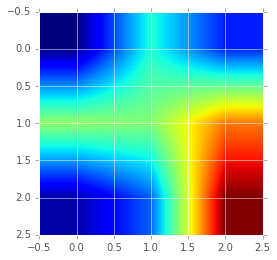

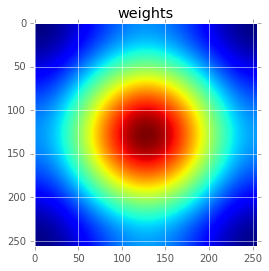

old _weights (3, 3, 3, 64)
new weights (256, 256, 1)
a


In [132]:
old_weights = model.get_weights()
model.set_weights(old_weights)
print(np.asanyarray(old_weights[0].shape))
# print(old_weights)
#find the mask prediction in weights
mask = old_weights[0][:,:,0]
print("mask shape",mask.shape)
mask = np.argmax(mask, axis=-1).squeeze().astype(np.uint8)
print(mask.shape)
plt.imshow(mask)
plt.show()
#choose model starting weights so the mask prediction is a sphere in the middle of the image
weights = np.zeros((256,256,1))
weights[128,128,0] = 1
weights = gaussian_filter(weights, sigma=70)
weights = weights/np.max(weights)
#reshape weights to match model
# weights = np.repeat(weights, 3, axis=1)
# weights = np.expand_dims(weights, axis=0)

plt.imshow(weights)

plt.title("weights")
plt.show()
print(f"old _weights" ,old_weights[0].shape)
print("new weights" ,weights.shape)
#reshape weights to match model
model.load_weights(model_path)
print("a")




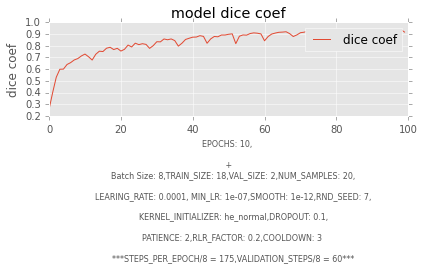


    Batch Size: 8,TRAIN_SIZE: 18,VAL_SIZE: 2,NUM_SAMPLES: 20,

    LEARING_RATE: 0.0001, MIN_LR: 1e-07,SMOOTH: 1e-12,RND_SEED: 7,

    KERNEL_INITIALIZER: he_normal,DROPOUT: 0.1,

    PATIENCE: 2,RLR_FACTOR: 0.2,COOLDOWN: 3 

    ***STEPS_PER_EPOCH/8 = 175,VALIDATION_STEPS/8 = 60***
    


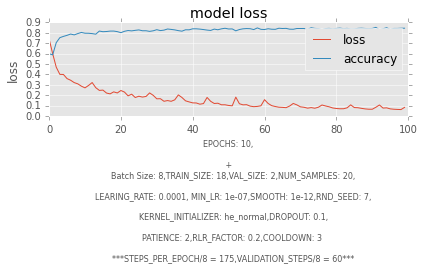

In [138]:
#plot model history
"""README.mdEPOCHS = 100
BATCH_SIZE = 20
TRAIN_SIZE  = 0.75
VAL_SIZE = 0.25
NUM_SAMPLES = 1000
LEARING_RATE = 1e-4
MIN_LR = 1e-7
SMOOTH = 1e-10
RND_SEED = 7
KERNEL_INITIALIZER = "he_normal"
DROPOUT = 0.01
PATIENCE = 2
RLR_FACTOR = 0.2
COOLDOWN = 3
"""
plt.style.use("ggplot")
iteration_string = f"""
    Batch Size: {BATCH_SIZE},TRAIN_SIZE: {TRAIN_SIZE},VAL_SIZE: {VAL_SIZE},NUM_SAMPLES: {NUM_SAMPLES},\n
    LEARING_RATE: {LEARING_RATE}, MIN_LR: {MIN_LR},SMOOTH: {SMOOTH},RND_SEED: {RND_SEED},\n
    KERNEL_INITIALIZER: {KERNEL_INITIALIZER},DROPOUT: {DROPOUT},\n
    PATIENCE: {PATIENCE},RLR_FACTOR: {RLR_FACTOR},COOLDOWN: {COOLDOWN} \n
    ***STEPS_PER_EPOCH/8 = {STEPS_PER_EPOCH},VALIDATION_STEPS/8 = {VALIDATION_STEPS}***
    """
plt.plot(model.history.history["dice_coef"], label='train')
plt.title('model dice coef')
plt.ylabel('dice coef')
plt.xlabel(f"EPOCHS: {EPOCHS}, \n \n + {iteration_string}", fontsize=8)
plt.legend(['dice coef'])
# increase padding around the figure
plt.tight_layout()
plt.show()
print(iteration_string)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history["accuracy"], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(f"EPOCHS: {EPOCHS},\n\n + {iteration_string}", fontsize=8)
plt.legend(["loss", "accuracy"])
# increase padding around the figure
plt.tight_layout()
plt.show()

In [ ]:
plt.style.use("ggplot")
iteration_string = f"""
    Batch Size: {BATCH_SIZE},TRAIN_SIZE: {TRAIN_SIZE},VAL_SIZE: {VAL_SIZE},NUM_SAMPLES: {NUM_SAMPLES},\n
    LEARING_RATE: {LEARING_RATE}, MIN_LR: {MIN_LR},SMOOTH: {SMOOTH},RND_SEED: {RND_SEED},\n
    KERNEL_INITIALIZER: {KERNEL_INITIALIZER},DROPOUT: {DROPOUT},\n
    PATIENCE: {PATIENCE},RLR_FACTOR: {RLR_FACTOR},COOLDOWN: {COOLDOWN}
    """
plt.plot(model.history["dice_coef"], label='train')
plt.title('model dice coef')
plt.ylabel('dice coef')
plt.xlabel(f"EPOCHS: {EPOCHS}, \n \n + {iteration_string}", fontsize=8)
plt.legend(['dice coef'])
# increase padding around the figure
plt.tight_layout()
plt.show()
print(iteration_string)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history["accuracy"], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(f"EPOCHS: {EPOCHS},\n\n + {iteration_string}", fontsize=8)
plt.legend(["loss", "accuracy"])
# increase padding around the figure
plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 757ms/step


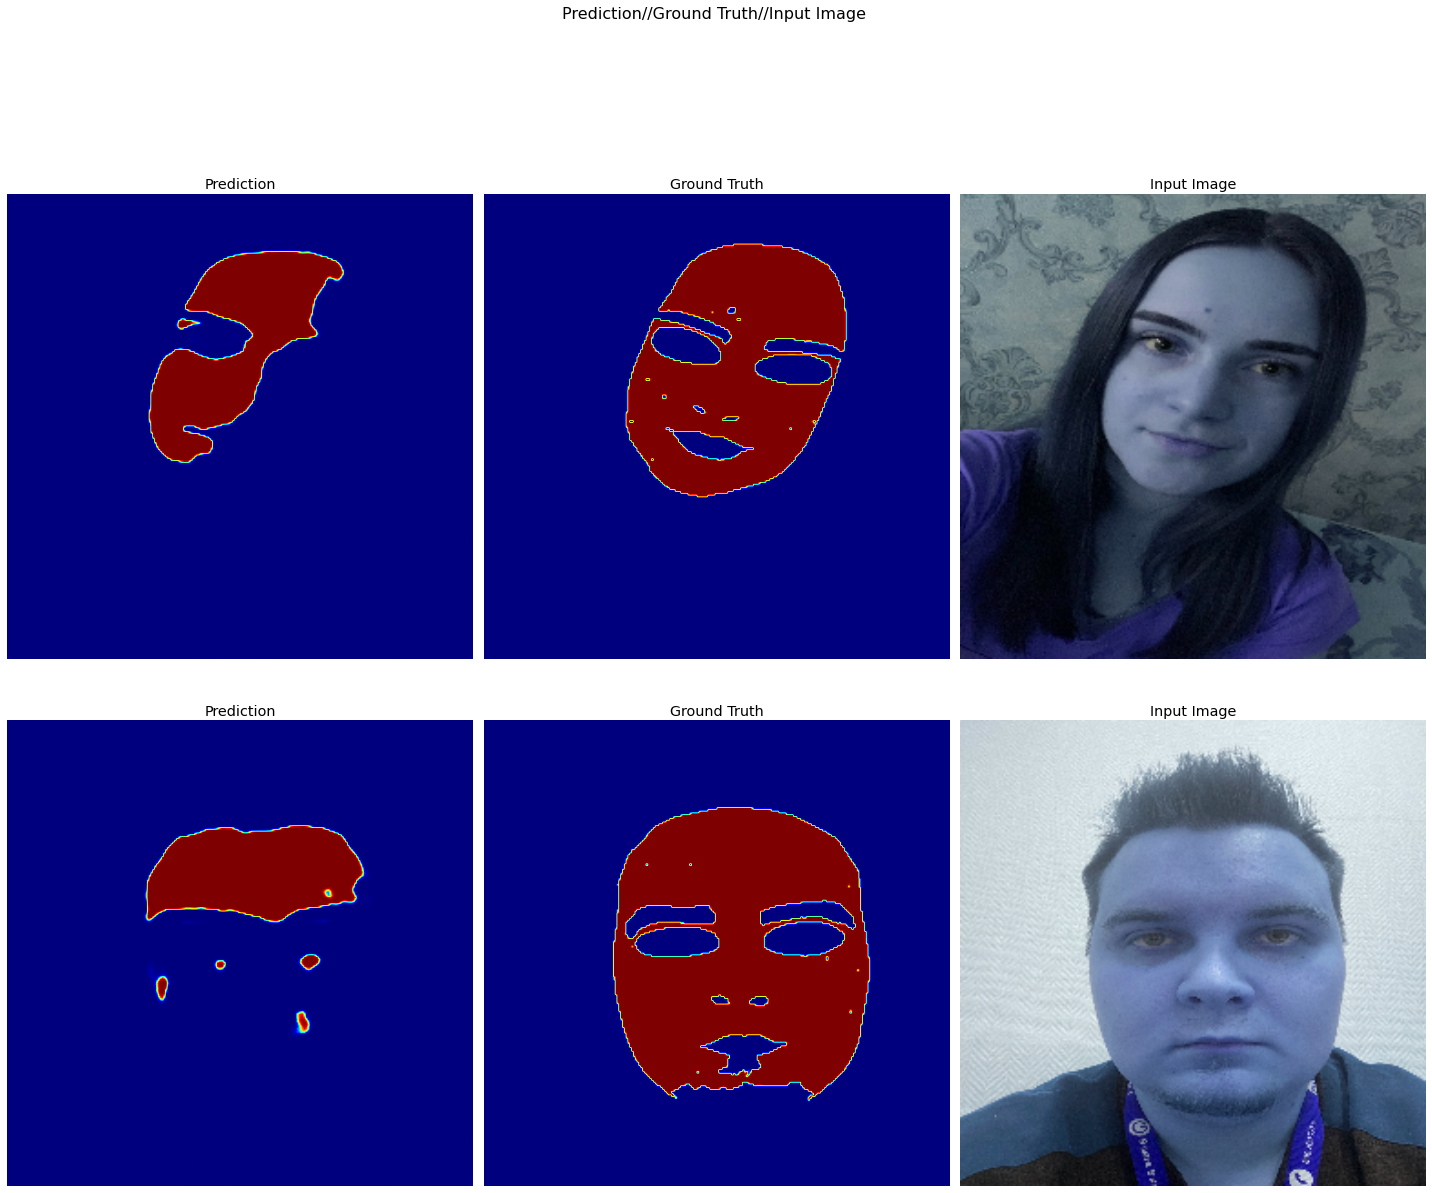

In [140]:



NORM = mpl.colors.Normalize(vmin=0, vmax=1)
# select a validation data batch
img, mask = next(iter(val))
# make prediction

mask = test_y[0:8]
img = test_X[0:8]
pred = model.predict(img)
plt.figure(figsize=(20,30))
# plt.title('Predictions//Ground Truth//Input Image')
k = 0
for i in pred:
    #get av pixel value

    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    # i = tf.argmax(i, axis=-1)
    # i = np.reshape(i, (256, 256, 1))
    
    plt.imshow(i*255.0, cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    # display_segmented_image(i, input_image=img[k], ax=plt.gca())
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)

    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k], cmap='gray')
    plt.axis('off')
    plt.title('Input Image')
    k += 1

plt.suptitle('Prediction//Ground Truth//Input Image \n ', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Load Model From JSON

In [69]:
from keras.models import load_model
from keras.models import model_from_json
import json

with open('model_in_json.json','r') as f:
    model_json = json.load(f)

model_reload = model_from_json(model_json)
# model_reload.load_weights('model_weights.h5')

In [74]:
# model_reload.summary()
MODEL_RELOAD = model_reload.weights
MODEL_RELOAD = model_reload.get_weights()
# print(MODEL_RELOAD)


(2, 256, 256, 3)
1/1 [==============================] - 0s 17ms/step


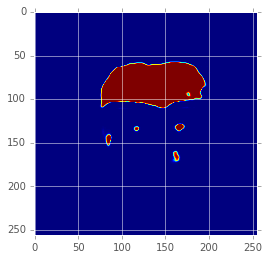

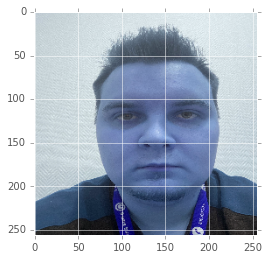

(256, 256, 1)
(256, 256, 3)


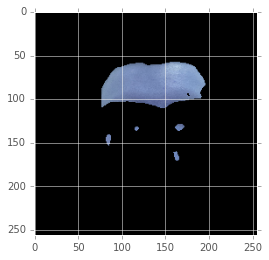

In [156]:
#load image
transform = T.ToPILImage()



test_set = test_X[:4]
print(test_set.shape)


predictions = model.predict(test_set)
#with gpu

pred_1 = predictions[1]

plt.imshow(pred_1, cmap='jet')
plt.show()
plt.imshow(test_X[1])
plt.show()
#use mask to get skin from image
mask_pred = pred_1
mask_pred = np.where(mask_pred > 0.5, 1, 0)
original_image = test_X[1]
print(mask_pred.shape)
print(original_image.shape)
skin_pred = np.multiply(mask_pred, original_image)
plt.imshow(skin_pred)
plt.show()
# img = cv2.imread('image.png')


1/1 [==============================] - 0s 19ms/step


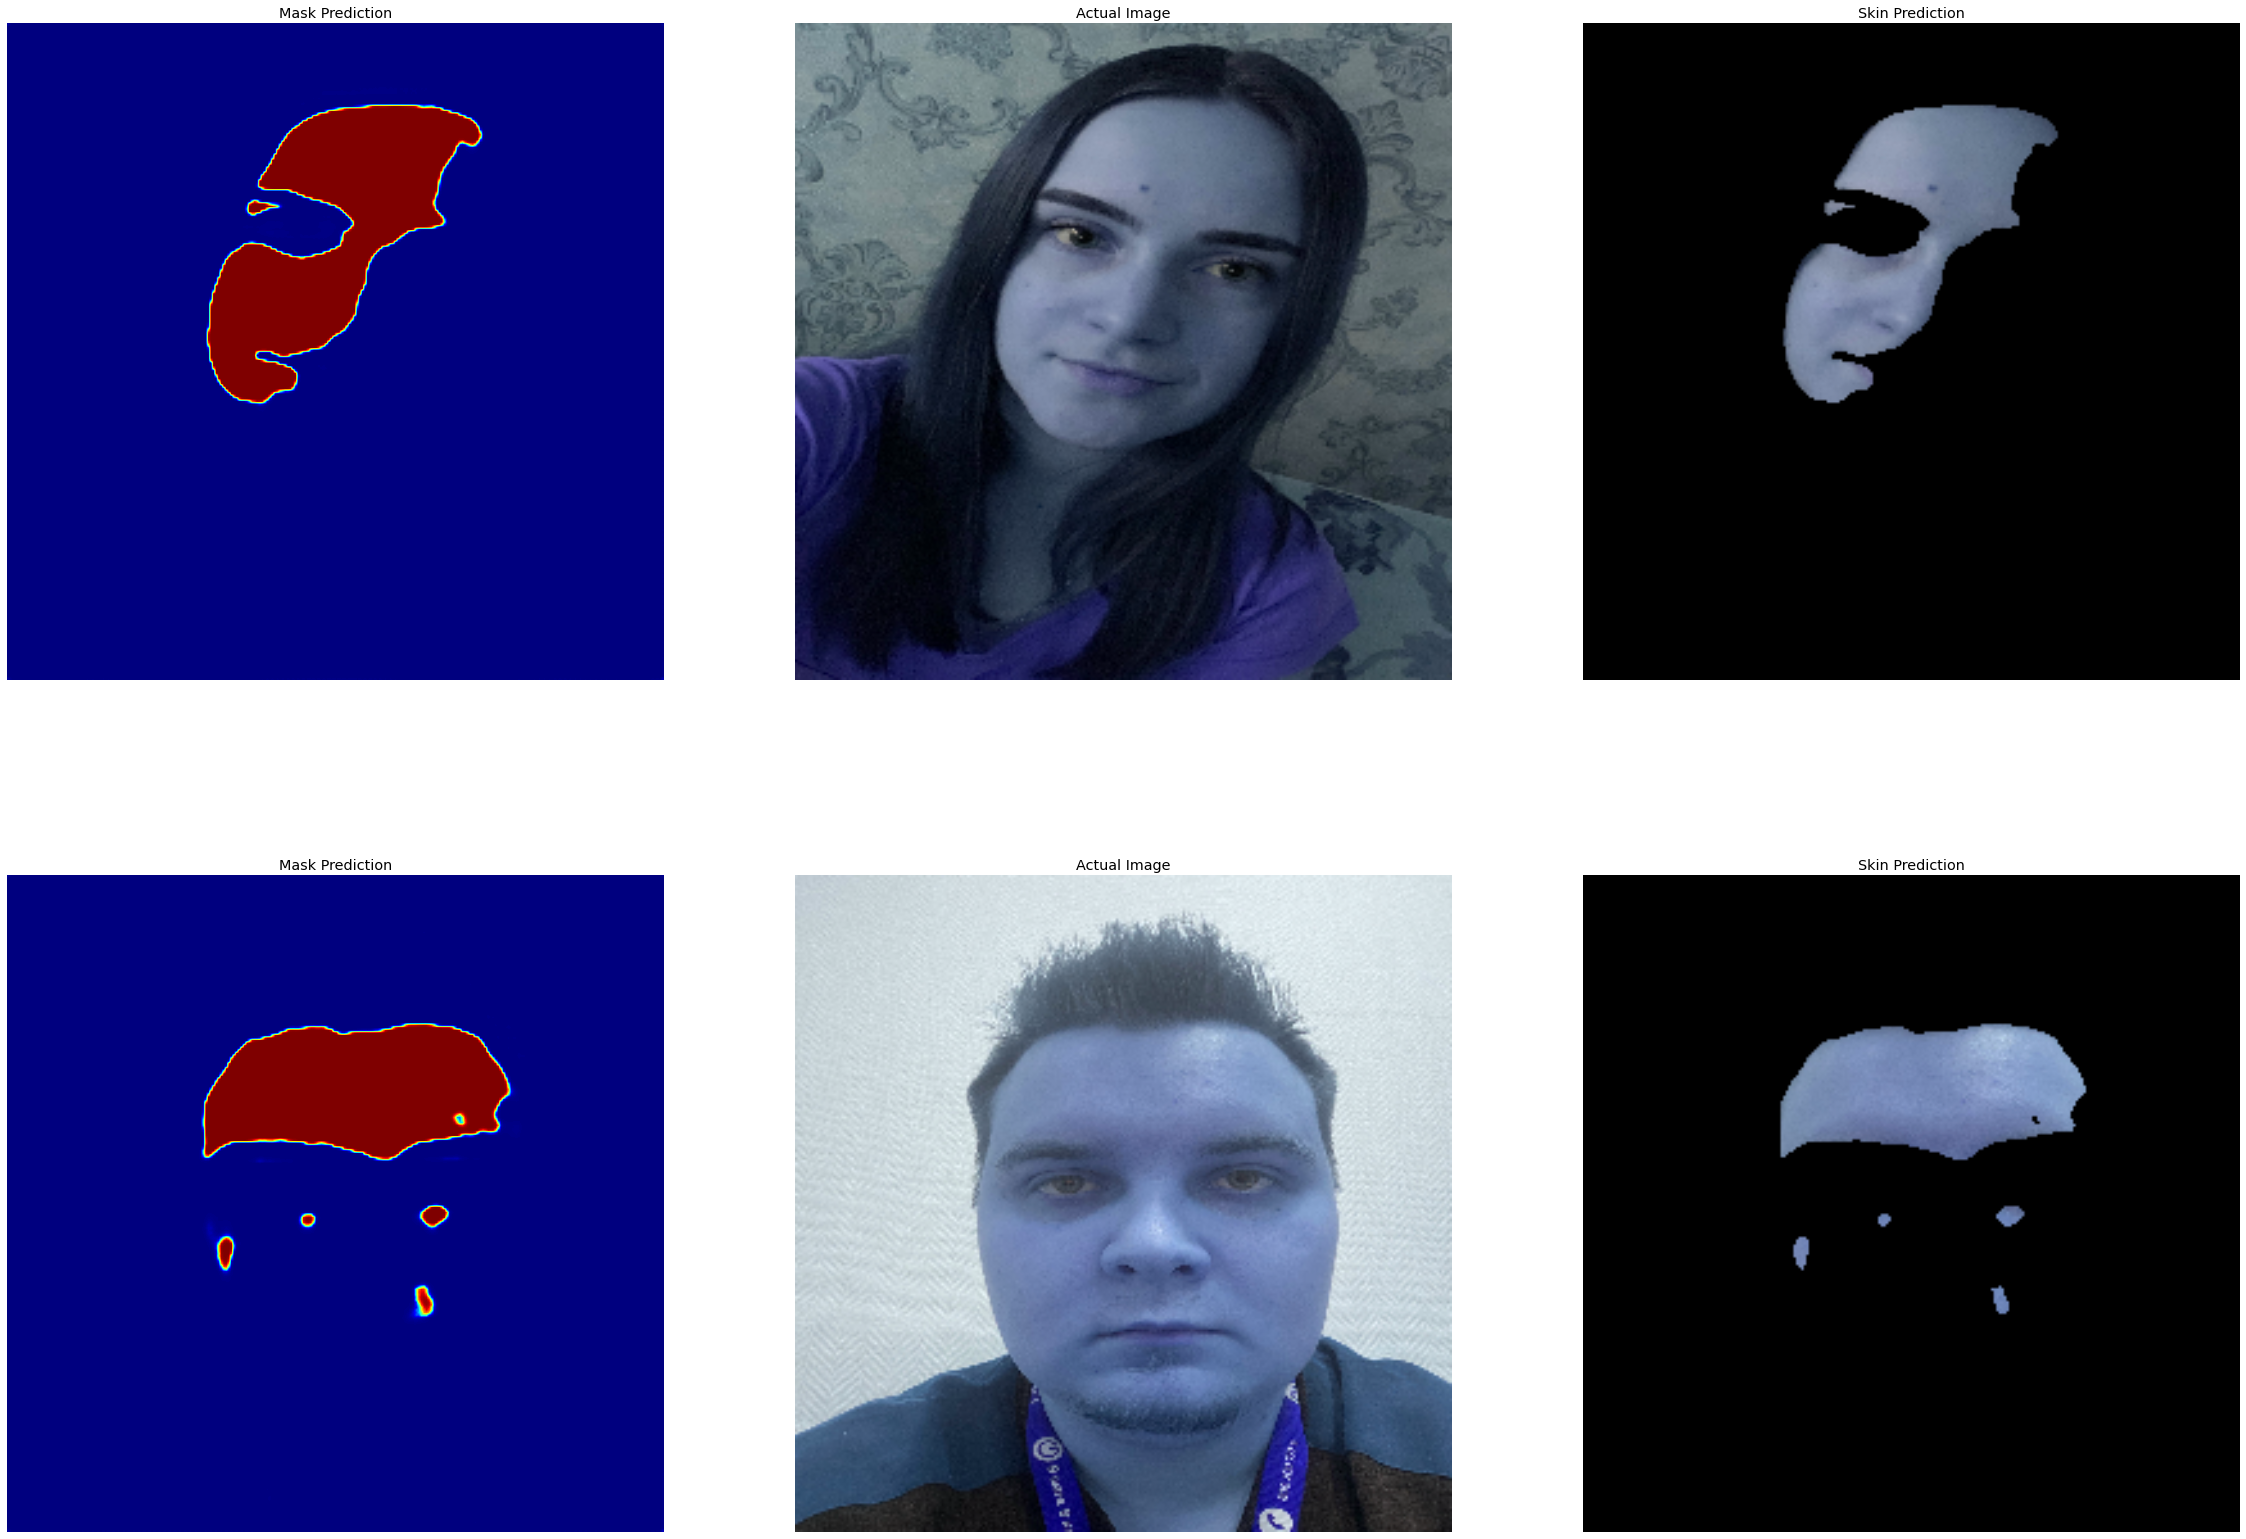

In [159]:
# select a validation data batch
# img, mask = next(iter(val))
index = 3
img = img[:index]
mask = mask[:index]


fig,ax = plt.subplots(2, 3, figsize=(40, 28))

# mask = test_y[:5]
# img = test_X[:5]
# make prediction
pred = model.predict(img)
k = 0
for i in pred:
    # plot the predicted mask
    # plt.subplot(4,4,1+k)

    # plt.imshow(i,cmap='jet')
    # plt.axis('off')
    # plt.title('Prediction')
    ax[k, 0].imshow(i, cmap='jet')
    ax[k, 0].axis('off')
    ax[k, 0].set_title('Mask Prediction')
    
    
    # plot the actual image
    # plt.subplot(4,4,3+k)
    # plt.imshow(img[k])
    # plt.axis('off')
    # plt.title('Actual Image')
    ax[k, 1].imshow(img[k])
    ax[k, 1].axis('off')
    ax[k, 1].set_title('Actual Image')


    pred_thresh = np.where(i > 0.5, 1, 0)
    original_image = img[k]
    skin_pred = np.multiply(pred_thresh, original_image)
    # plt.subplot(4,4,4+k)
    # plt.imshow(skin_pred)
    # plt.axis('off')
    # plt.title('Skin Prediction')
    ax[k, 2].imshow(skin_pred)
    ax[k, 2].axis('off')
    ax[k, 2].set_title('Skin Prediction')
    
    
    k += 1





